<a href="https://colab.research.google.com/github/bevislau/bevisportfolio/blob/main/RFM_Customer_Segmentation_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# RFM Analysis for E-commerce Customers
This notebook documents the process and insights from performing an RFM (Recency, Frequency, Monetary) analysis on customer purchase data using BigQuery and Looker Studio.

In this example, Bigquery theLook eCommerce sample database is used
https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce?inv=1&invt=Abzkig&project=magnetic-flare-399214

There are 4 key steps

1.   Data Exploration & Preparation
2.   Segmentation Logic (RFM Scoring)
3.   Data Analysis
4.   Recommendations & Future



# Data Exploration & Preparation

There are 3 tables to be used in this project , users, orders and order_items

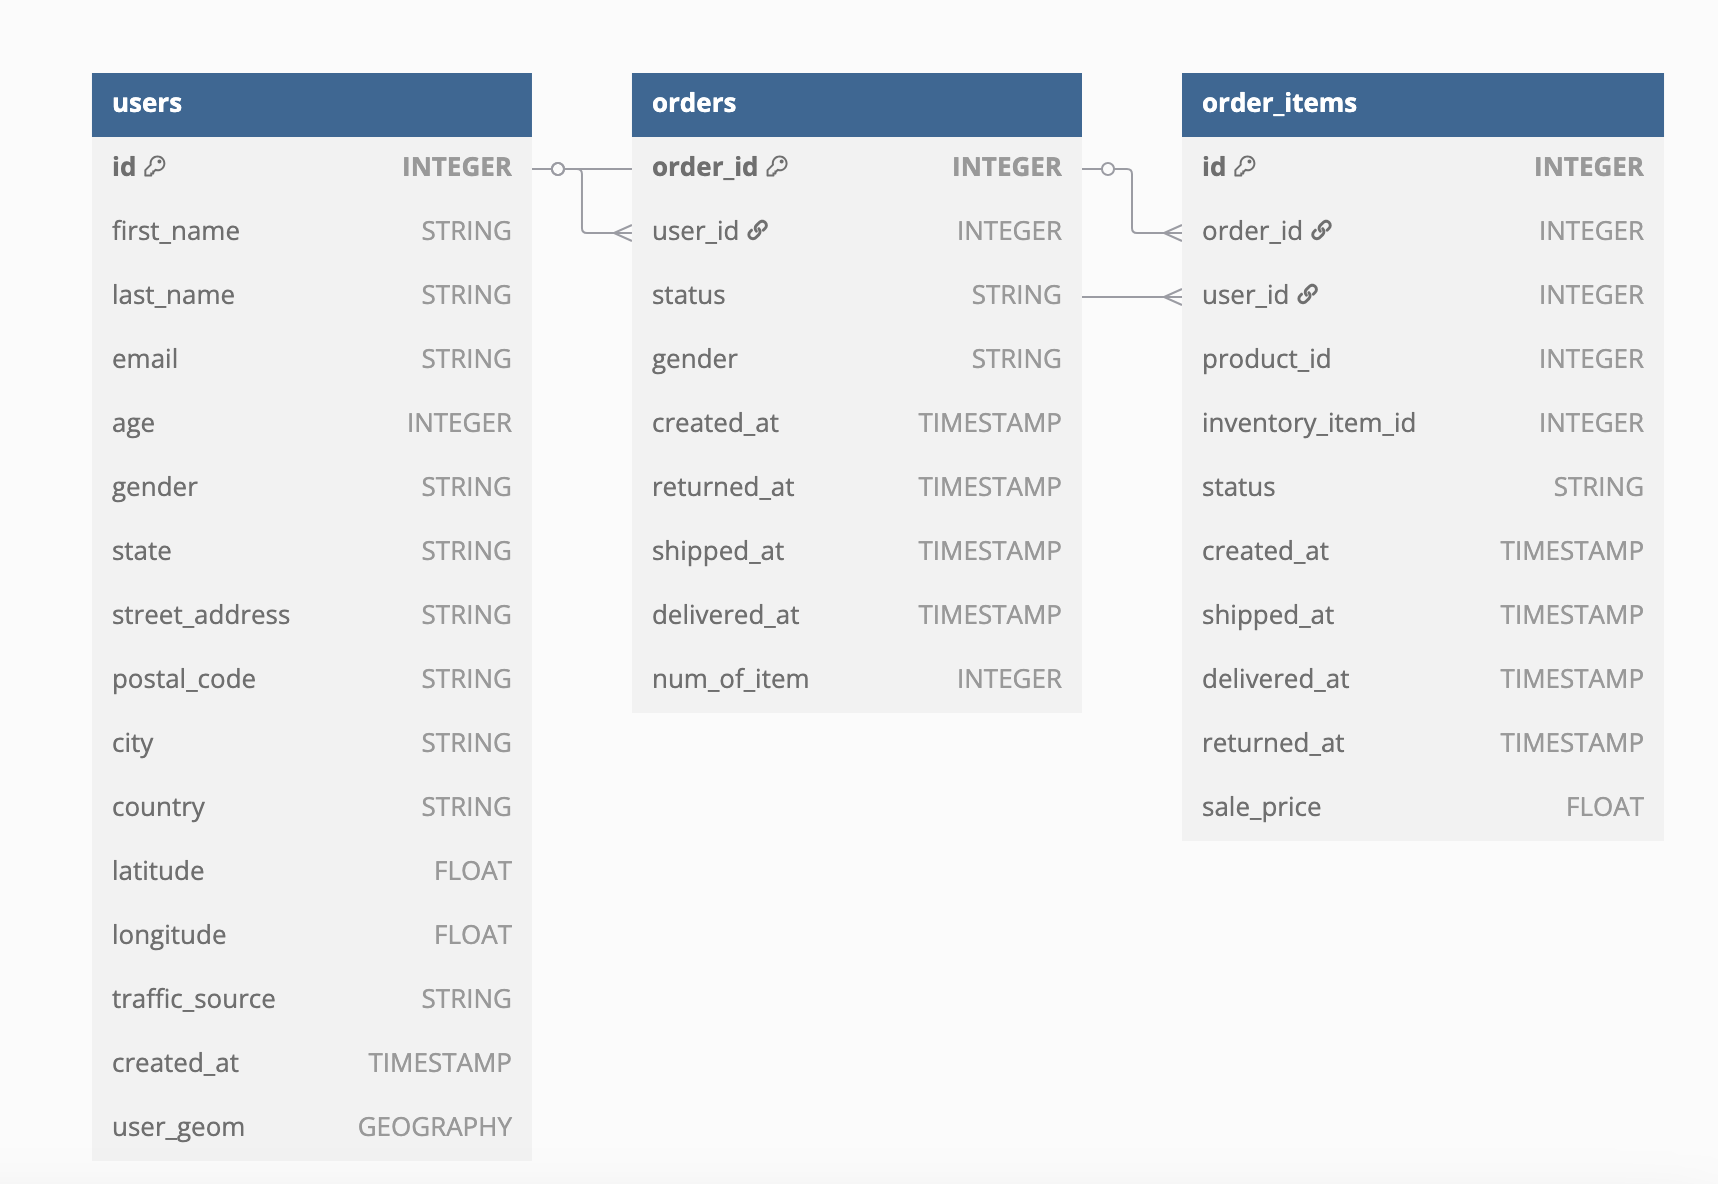

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='gifted-country-461816-i9')

## Top 10 customers with highest lifetime value

Customer_total_purchase is calcualted from order_items total with sales price , this is due to the order_items are having each item purchase as a row

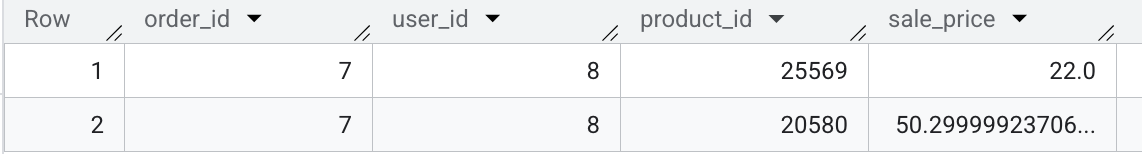

In [ ]:
query = """
--- orders table and order_items to obtain the lifetime value of customer
--- order_id_value

--order_id_value
WITH order_table AS (
SELECT user_id, ROUND(SUM(sale_price),2) AS customer_total_purchase
FROM gifted-country-461816-i9.thelook_ecommerce_data.order_items
GROUP BY user_id
)
--JOIN users table for details
SELECT u.first_name,u.last_name,u.age,u.gender,u.email, ot.customer_total_purchase
FROM gifted-country-461816-i9.thelook_ecommerce_data.users u
LEFT JOIN order_table ot
ON ot.user_id = u.id
ORDER BY ot.customer_total_purchase DESC
LIMIT 10

"""

df = client.query(query).to_dataframe()
display(df)




,first_name,last_name,age,gender,email,customer_total_purchase
0,Joshua,Allison,46,M,joshuaallison@example.net,1657.00
1,Ralph,Shelton,43,M,ralphshelton@example.com,1615.78
2,Stephen,Mosley,41,M,stephenmosley@example.org,1520.35
3,Dwayne,Andrade,62,M,dwayneandrade@example.net,1519.82
4,Charles,Decker,57,M,charlesdecker@example.net,1482.94
5,Jill,Terrell,51,F,jillterrell@example.org,1439.99
6,Timothy,Joyce,63,M,timothyjoyce@example.com,1421.07
7,Ryan,Mills,17,M,ryanmills@example.com,1406.09
8,Kenneth,Holmes,43,M,kennethholmes@example.com,1397.65
9,Brandon,Cummings,32,M,brandoncummings@example.net,1390.52


## Check for order status

We have to consider there is potential cancel and refunded order

In [ ]:
query = """
SELECT DISTINCT status ,count(*) AS no_of_record
FROM `gifted-country-461816-i9.thelook_ecommerce_data.orders`
GROUP BY status
"""

df = client.query(query).to_dataframe()
display(df)

,status,no_of_record
0,Cancelled,18722
1,Complete,31161
2,Processing,24999
3,Returned,12423
4,Shipped,37404


In [ ]:
query = """
SELECT user_id, recency, frequency, monetary_value,
       recency_rank, frequency_rank, monetary_rank,
       CASE
           WHEN recency_rank = 1 AND frequency_rank <=2 AND monetary_rank = 1 THEN 'Champion'
           WHEN recency_rank = 1 AND frequency_rank >= 4 AND monetary_rank <= 2 THEN 'High-Spending New Customers'
           WHEN recency_rank = 1 AND frequency_rank >= 2 AND monetary_rank <= 3 THEN 'Low-Spending Loyal Customers'
           WHEN recency_rank >= 4 AND frequency_rank <= 2 AND monetary_rank <= 2 THEN 'Churned and Win Back Customers'
           WHEN recency_rank >= 4 AND frequency_rank >= 4 AND monetary_rank >= 4 THEN 'Lost'
           ELSE 'Others'
       END AS customer_segment
FROM `gifted-country-461816-i9.thelook_ecommerce_data.RFM_segmentation`
ORDER BY user_id
"""

df = client.query(query).to_dataframe()
df.head()




,user_id,recency,frequency,monetary_value,recency_rank,frequency_rank,monetary_rank,customer_segment
0,1,156,2,78.91,2,1,3,Others
1,2,656,1,70.00,5,5,3,Others
2,4,254,2,29.98,3,2,4,Others
3,6,257,1,29.95,3,4,4,Others
4,19,134,1,17.66,2,4,5,Others


# RFM Segmentation Preparation



### Renecy = the last customer purchase date  
=> DATE_DIFF(CURRENT_DATE(),DATE(MAX(o.created_at)) , DAY)

### Frequency = how frequent a customer make a purchase
=> count(o.order_id) AS frequency,

### Monetary Value = total purchase value of a customer
=> customer_total_purchase

In [ ]:
query = """
-- Understand the R,F,M
SELECT o.user_id ,
DATE_DIFF(CURRENT_DATE(),DATE(MAX(o.created_at)) , DAY)  AS recency ,
count(o.order_id) AS frequency,
ROUND(SUM(oi.sale_price), 2) AS monetary_value
FROM `gifted-country-461816-i9.thelook_ecommerce_data.orders` o
LEFT JOIN `gifted-country-461816-i9.thelook_ecommerce_data.order_items` oi
ON o.order_id = oi.order_id
WHERE DATE(o.created_at) BETWEEN DATE('2023-01-01') AND CURRENT_DATE() AND o.status = 'Complete' -- date between today and also make sure order is valid
GROUP BY user_id
ORDER BY user_id ASC
"""
df = client.query(query).to_dataframe()
df.head()

,user_id,recency,frequency,monetary_value
0,1,158,2,78.91
1,2,658,1,70.00
2,4,256,2,29.98
3,6,259,1,29.95
4,19,136,1,17.66


This segmentation uses RFM scores (Recency, Frequency, Monetary), each ranked into 5 tiers (1 = best, 5 = worst). The logic assigns each user into a behavioral segment to support targeted marketing and engagement strategies

Recency Tier = 1 (Most recent customers) <br>
Frequency Tier = 1 (Most frequent purchases) <br>
Monetary Tier = 1 (Highest customer lifetime value)



In [ ]:
query ="""
WITH customer_segment AS (
SELECT user_id, recency,frequency,monetary_value,
NTILE (5) OVER (ORDER BY recency ASC) AS recency_rank,
NTILE (5) OVER (ORDER BY frequency DESC) AS frequency_rank,
NTILE (5) OVER (ORDER BY monetary_value DESC) AS monetary_rank,
FROM `gifted-country-461816-i9.thelook_ecommerce_data.RFM`
)
SELECT
  user_id, recency,frequency,monetary_value,recency_rank,frequency_rank,monetary_rank,

CASE
    WHEN recency_rank = 1 AND frequency_rank <=2 AND monetary_rank = 1 THEN 'Champion'
    WHEN recency_rank = 1 AND frequency_rank >= 4 AND monetary_rank <= 2 THEN 'High-Spending New Customers'
    WHEN recency_rank <= 2 AND frequency_rank <= 2 AND monetary_rank <= 2 THEN 'Loyal Customers High-Spending'
    WHEN recency_rank <= 2 AND frequency_rank <= 2 AND monetary_rank >= 3 THEN 'Loyal Customers Low-Spending '
    WHEN recency_rank >= 4 AND frequency_rank <= 2 AND monetary_rank <= 2 THEN 'Churned and Win Back Customers'
    WHEN recency_rank >= 4 AND frequency_rank >= 4 AND monetary_rank >= 4 THEN 'Lost'
    ELSE 'Others'
  END AS customer_segment

FROM customer_segment
ORDER BY recency_rank,frequency_rank,monetary_rank

"""
df = client.query(query).to_dataframe()
df.head()

,user_id,recency,frequency,monetary_value,recency_rank,frequency_rank,monetary_rank,customer_segment
0,79959,43,5,437.99,1,1,1,Champion
1,27393,63,4,436.44,1,1,1,Champion
2,99076,55,3,432.49,1,1,1,Champion
3,51185,8,4,428.44,1,1,1,Champion
4,1141,12,4,275.42,1,1,1,Champion


### 💎 Champion
**Condition:**  
`recency_rank = 1 AND frequency_rank <= 2 AND monetary_rank = 1`

**Interpretation:**  
Highly engaged, loyal customers who have purchased very recently, do so frequently, and spend a lot. They represent the top-value customers.

---

### 🆕 High-Spending New Customers
**Condition:**  
`recency_rank = 1 AND frequency_rank >= 4 AND monetary_rank <= 2`

**Interpretation:**  
Recently acquired customers who have not purchased often but made high-value purchases. They show strong potential.

---

### 📈 Low-Spending Loyal Customers
**Condition:**  
`recency_rank = 1 AND frequency_rank >= 2 AND monetary_rank <= 3`

**Interpretation:**  
These customers purchase regularly and recently, but tend to spend smaller amounts. They’re consistent but lower value.

---

### 🔁 Churned and Win Back Customers
**Condition:**  
`recency_rank >= 4 AND frequency_rank <= 2 AND monetary_rank <= 2`

**Interpretation:**  
These users haven’t engaged in a long time, and showed low activity and spend previously. They're close to being lost.

---

### ❌ Lost
**Condition:**  
`recency_rank >= 4 AND frequency_rank >= 4 AND monetary_rank >= 4`

**Interpretation:**  
Customers with poor engagement across all RFM metrics — not recent, not frequent, and low-spending.

---

## Combine the RFM tier into customer_table

In [ ]:
query = """
SELECT
  u.*,
  r.customer_segment,r.monetary_rank,r.monetary_value,r.recency,r.recency_rank,r.frequency,r.frequency_rank
FROM
  `gifted-country-461816-i9.thelook_ecommerce_data.users` u
LEFT JOIN
  `gifted-country-461816-i9.thelook_ecommerce_data.RFM_segmentation` r
ON
  u.id = r.user_id
WHERE r.customer_segment IS NOT NULL
"""

df = client.query(query).to_dataframe()
df.head()

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,...,traffic_source,created_at,user_geom,customer_segment,monetary_rank,monetary_value,recency,recency_rank,frequency,frequency_rank
0,5187,Ryan,Martin,ryanmartin@example.net,16,M,Acre,111 Tammy Pike,69980-000,null,...,Search,2023-05-19 00:46:00+00:00,POINT(-72.87094866 -8.065346116),Others,2,129.96,275,3,3,1
1,54541,Hannah,Hunter,hannahhunter@example.org,43,F,Acre,018 Nelson Plaza,69980-000,null,...,Search,2019-09-17 07:48:00+00:00,POINT(-72.87094866 -8.065346116),Others,2,126.94,288,3,3,1
2,80151,Audrey,Benson,audreybenson@example.com,37,F,Acre,2517 Lane Freeway,69980-000,null,...,Search,2021-12-12 06:54:00+00:00,POINT(-72.87094866 -8.065346116),Others,5,11.79,230,3,1,5
3,15769,Hannah,Rivera,hannahrivera@example.org,64,F,Acre,13564 Larson Loaf,69980-000,null,...,Email,2021-03-31 14:55:00+00:00,POINT(-72.87094866 -8.065346116),Churned and Win Back Customers,1,353.00,387,4,2,2
4,60622,Denise,Daniels,denisedaniels@example.net,48,F,Acre,902 Gary Court,69970-000,Tarauacá,...,Search,2022-11-06 02:10:00+00:00,POINT(-71.55302951 -8.325245103),Churned and Win Back Customers,1,204.49,483,4,3,1


# Visualisation and Analysis

##Business Questions to answer:

How many potential customers to win back ? <br>
What are some characteristics of the segments in both behavioural and demographics ?



## Segment Summary

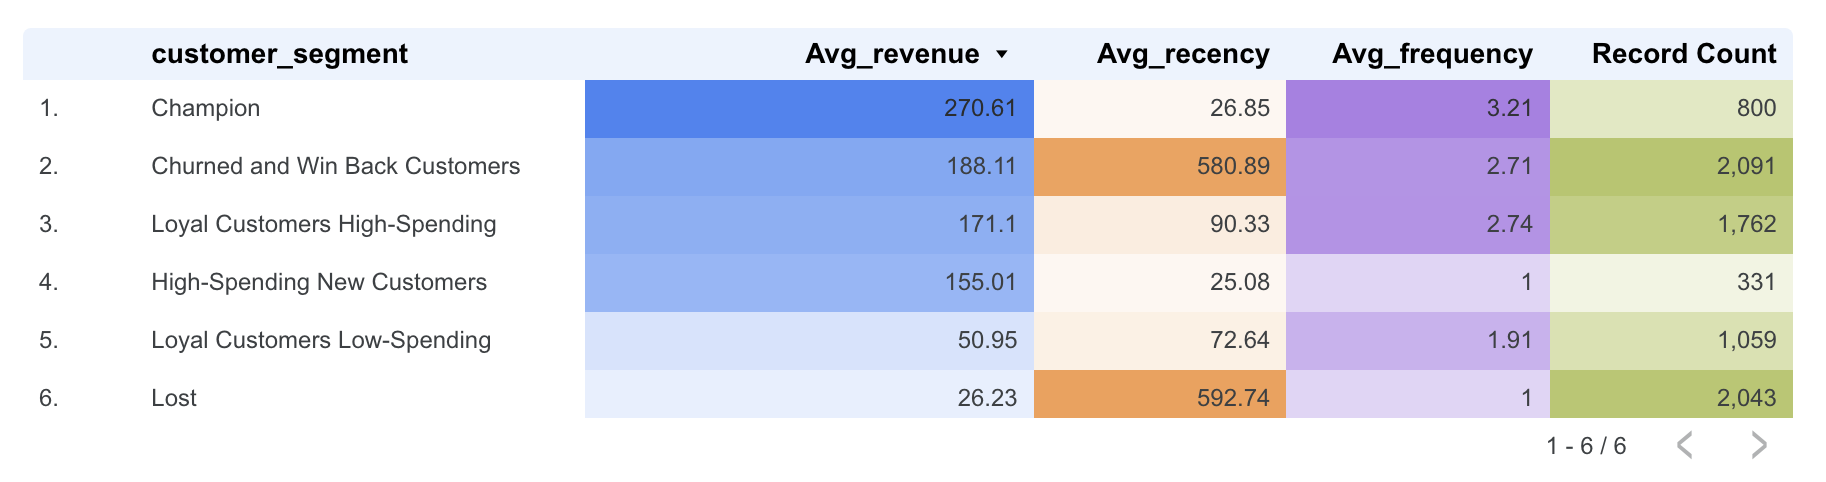

### Insight 1 : there is around 800 champion who always order and avg_renecy is 3 times higher than the 2nd tier, high spending loayl customer

=>It indicates improving the customers to visit the site can be potential strategies for those who already loyal and spending

### Insight 2 : Between High spending and Low spending lower customer , their revenue can be at least 3 times difference

=> Explore further about the category of products they purchase <br>
=> Push for cross-sell opportunity

### Insight 3: There are high potential to start campaign towards churned customer. It seems there used to be a high revenue purchase (188.11) among all segment and receney has been more than 1.5 years

=> Qualiative users interview to understand why they swtich or churn <br>
=> Promotional and Personalisation strategy with exclusive offer

### Top 10 VIP in Champion vs Others

This table shows the top 10 customers in Champion segment

It showed there are significant gap between the top 10 and other champion users

=> worth considering if there is pattern on what they buy

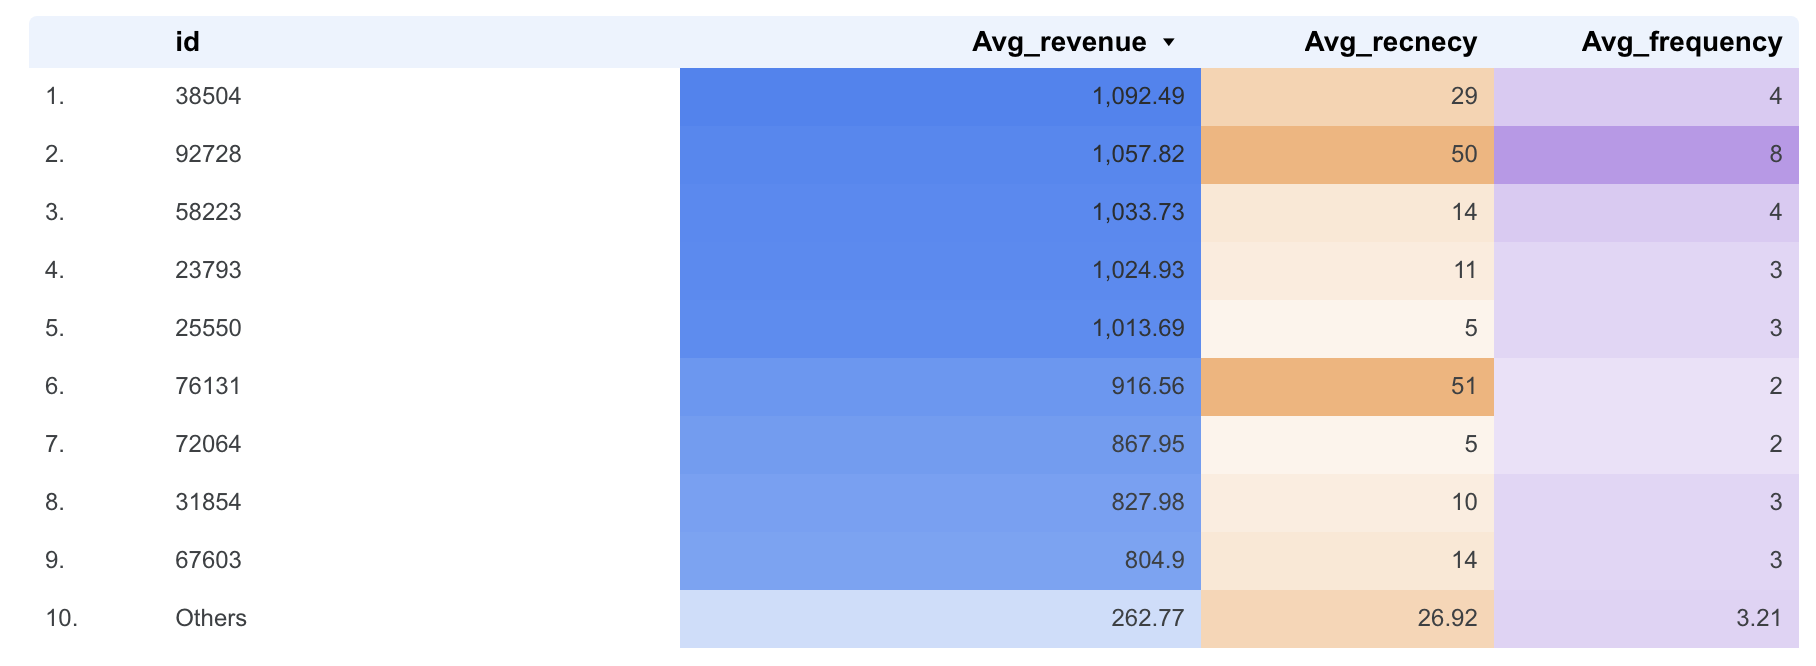

## Gender And Source of Purchase Breakdown


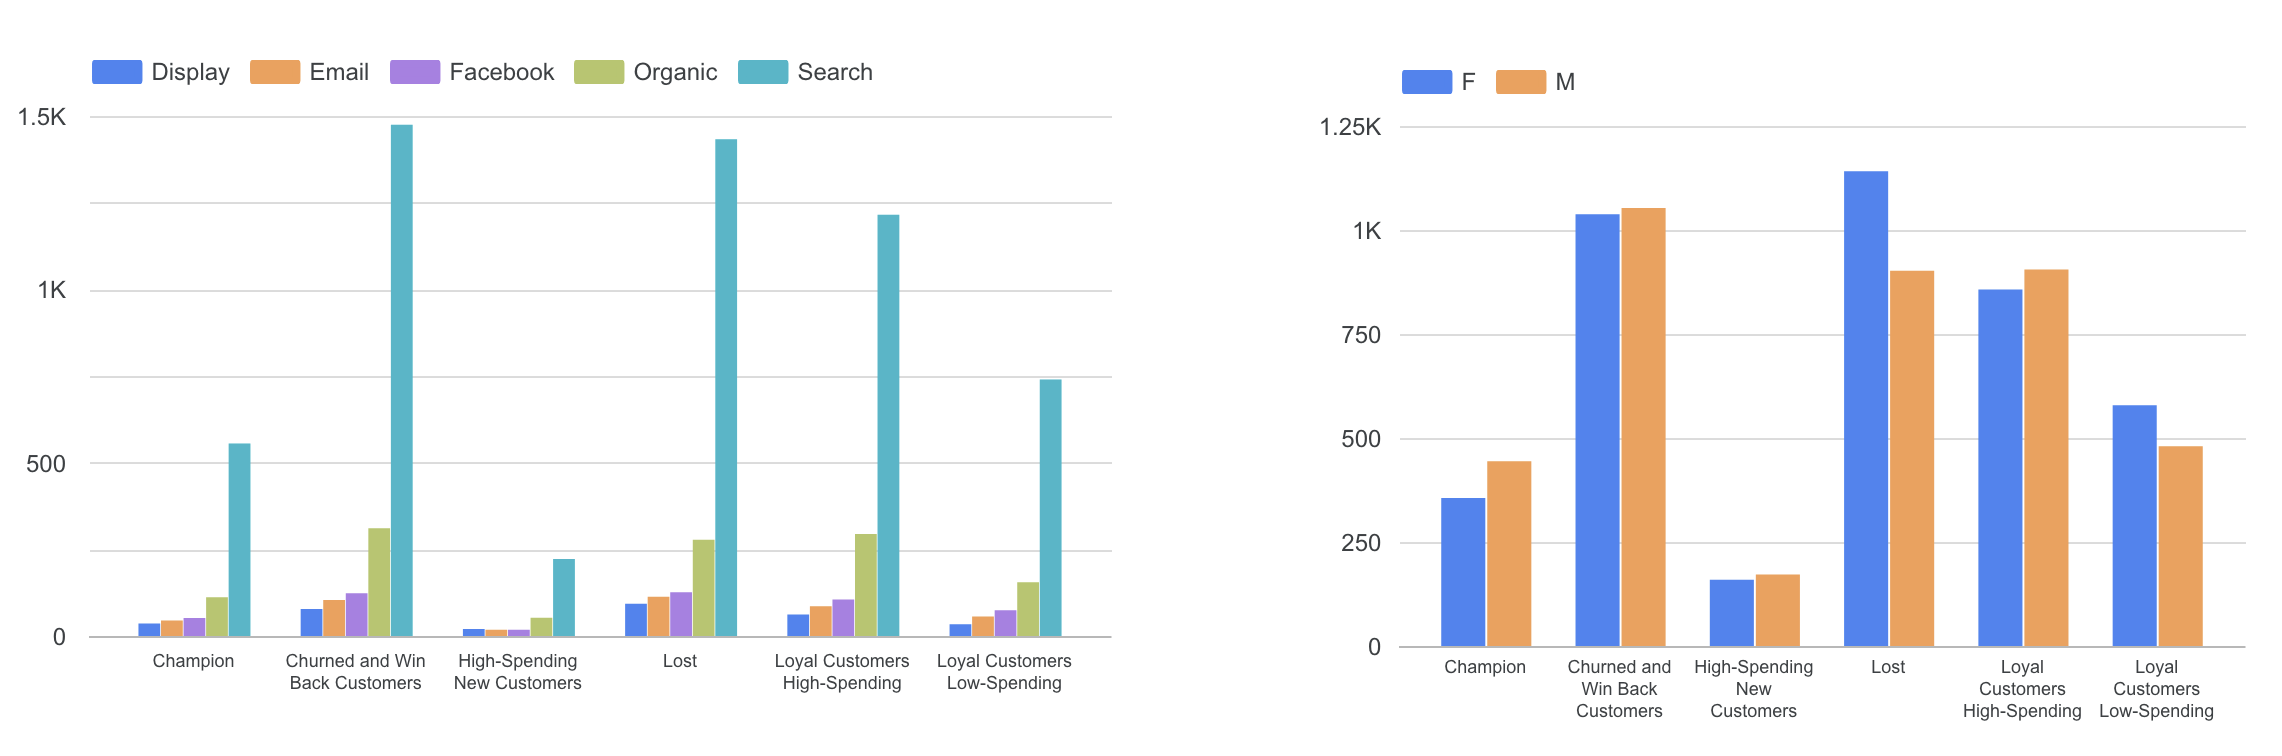

###Source of purchase

The top channels follows a general pattern:
Search > Organic > Facebook > Email > Display

=>work on % breakdown on each segment <br>
=>Consider the attribution topics on the sequence of purchase

On high spending new customer, the major channel of acuqisition was on Search

=>potential to explore if there are other marketing

###Gender Difference

In 'Champion' Segment , there are more Male vs Female

While for the lost customer, it is the opposite trend

=>check on the product purchase and whether there are correlation

## Country and Age Breakdown

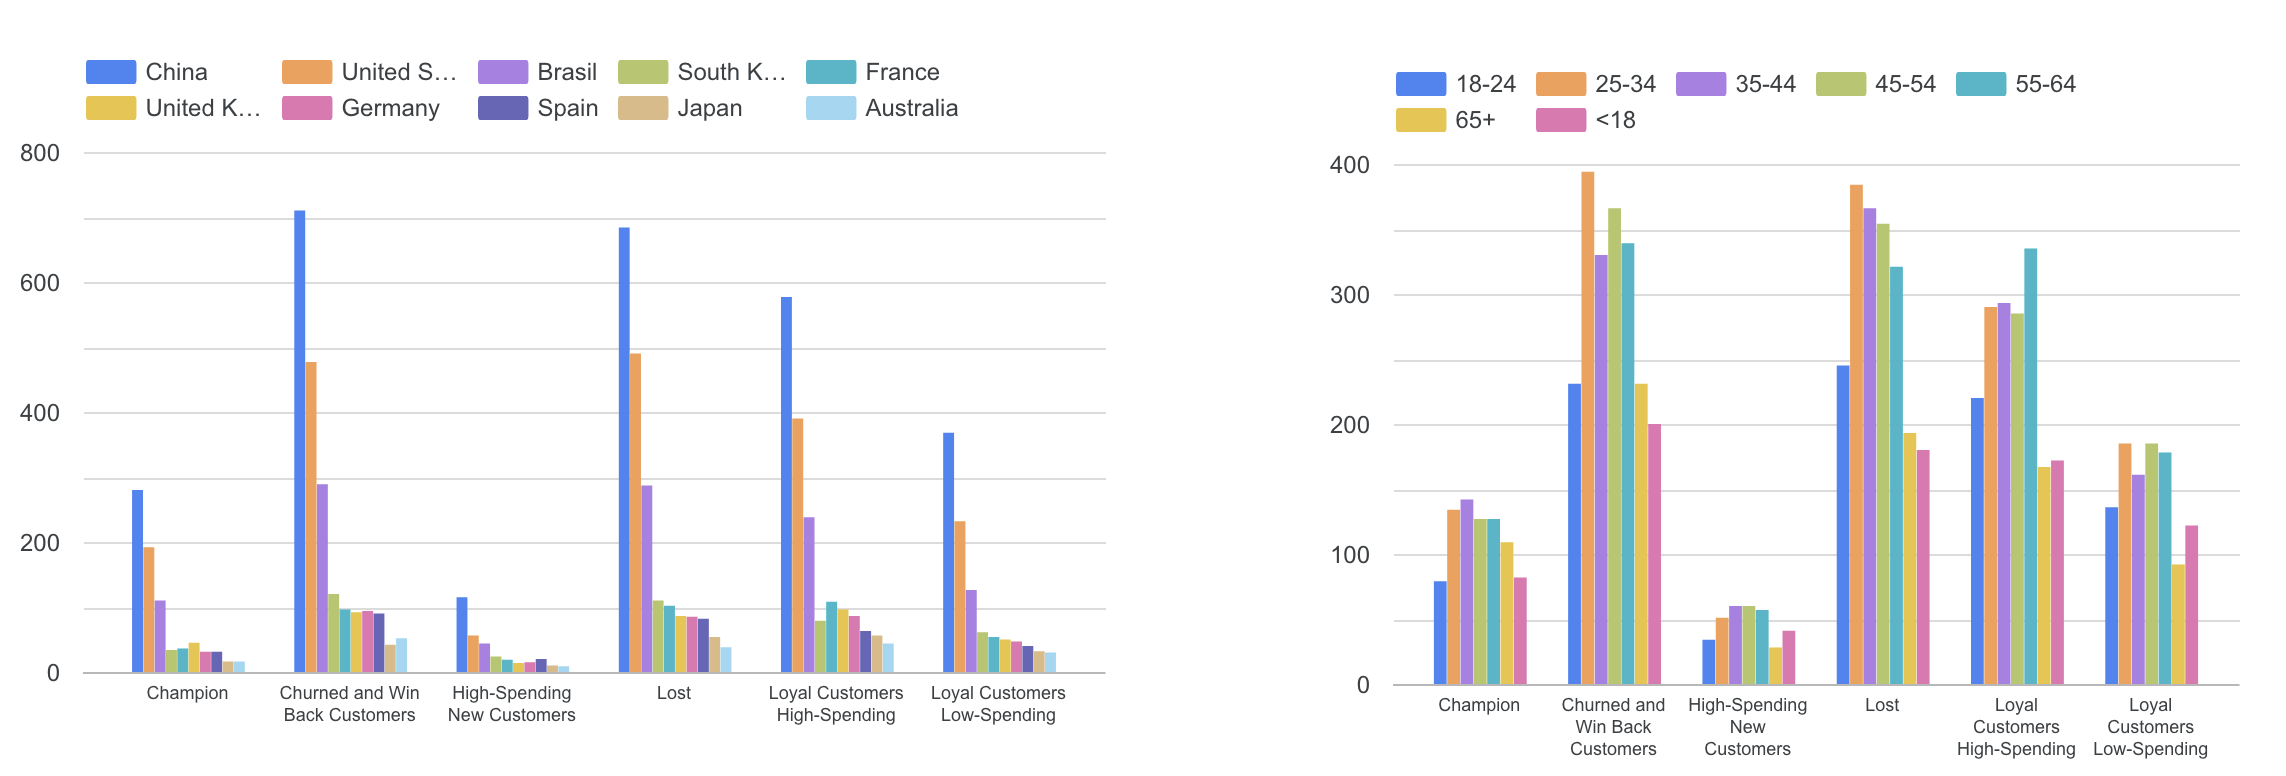

Age Demographics

Generally, the age group between 25-45 contributes to be the major part of customer

In Churned customer segmnet, 25-34 segment stood out among the others

In High-spending loyal customer, 55-64 age group has the highest number.

=> compare why champion 55-64 group vs loyal customer 55-64 group behaviour



# Recommendation and Future

# 🧠 RFM Customer Segmentation: Segment Descriptions

This segmentation uses **RFM scores** (Recency, Frequency, Monetary), each ranked into 5 tiers (1 = best, 5 = worst). The logic assigns each user into a behavioral segment to support targeted marketing and engagement strategies.

---

## 💎 Champion  
**Condition:**  
`recency_rank = 1 AND frequency_rank <= 2 AND monetary_rank = 1`

**Interpretation:**  
Highly engaged, loyal customers who have purchased **very recently**, do so **frequently**, and **spend a lot**. They represent the **top-value customers**.

**Next Steps:**  
- Offer loyalty perks or VIP programs  
- Provide early access to new products  
- Invite to referral or ambassador programs

---

## 🆕 High-Spending New Customers  
**Condition:**  
`recency_rank = 1 AND frequency_rank >= 4 AND monetary_rank <= 2`

**Interpretation:**  
Recently acquired customers who have **not purchased often** but made **high-value purchases**. They show **strong potential**.

**Next Steps:**  
- Encourage repeat purchases with discounts or personalized follow-ups  
- Educate on product range via email sequences  
- Send welcome offers or onboarding guides

---

## 📈 Low-Spending Loyal Customers  
**Condition:**  
`recency_rank = 1 AND frequency_rank >= 2 AND monetary_rank <= 3`

**Interpretation:**  
These customers purchase **regularly** and **recently**, but tend to spend **smaller amounts**. They’re consistent but lower value.

**Next Steps:**  
- Offer bundle deals or upsell opportunities  
- Introduce loyalty points for higher spend  
- Promote higher-margin products

---

## 🔁 Churned and Win Back Customers  
**Condition:**  
`recency_rank >= 4 AND frequency_rank <= 2 AND monetary_rank <= 2`

**Interpretation:**  
These users haven’t engaged **in a long time**, and showed **low activity and spend** previously. They're **close to being lost**.

**Next Steps:**  
- Launch re-engagement campaigns (“We miss you”)  
- Offer limited-time discounts or incentives  
- Ask for feedback to understand reasons for inactivity

---

## ❌ Lost  
**Condition:**  
`recency_rank >= 4 AND frequency_rank >= 4 AND monetary_rank >= 4`

**Interpretation:**  
Customers with **poor engagement across all RFM metrics** — not recent, not frequent, and low-spending.

**Next Steps:**  
- Consider deprioritizing or removing from active campaigns  
- Send final offer or survey to assess potential  
- Explore automated reactivation or low-cost reminders

---

## 📦 Others  
**Condition:**  
All remaining users not captured by other conditions.

**Interpretation:**  
These users have **mixed behavior** and don’t fit clearly into other segments.

**Next Steps:**  
- Consider deeper segmentation or add behavioral tags  
- Track over time to see if they move into clearer groups  
- Test engagement strategies to identify patterns

